<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/pruebas/LSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSA

En esta notebook vamos a descomponer en tópicos un conjunto de textos. La descomposición en tópicos pueden pensarla a la vez como un proceso de reducción dimensional, al describir los datos en el espacio de tópicos en vez del espacio original de features), o como un proceso de *clustering*, al agrupar los textos en dichos tópicos.

Vamos a aplicar LDA sobre el dataset de letras de tango visto en clases anteriores.

In [1]:
# Importamos las librerías habituales
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

In [2]:
# Importamos nltk para extraer stopwords 
import nltk 
nltk.download('stopwords')

# Librería para hacer wordclouds
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Objetos de sklearn para hacer tópicos
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf

# Algoritmos de descomposición de tópicos
from sklearn.decomposition import LatentDirichletAllocation

Cargamos el dataset con el que vamos a trabajar desde la carpeta de la materia. Vamos a utilizar el dataset de la clase de sentiment sobre letras de distintos ritmos musicales:

In [4]:
# Path de nuestro dataset
filename = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/02-01-correos-train-80.csv'

# Carga del dataset
df = pd.read_csv(filename)

# Vemos las primeras filas 
df.head()

,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
0,quería saber por qué no puedo acceder al bolet...,6,2,3,1,2019,2,7,4,1,1,3,4,107,0.0,0.775701,3,21,12,0.952381,0.000000,1,0,Boleto Universitario
1,no puedo reseterar mi clave de acceso al siste...,4,2,12,2,2015,0,2,1,1,1,5,6,419,0.0,0.809069,0,78,45,0.717949,0.007160,1,0,Problemas con la Clave
2,me dice que ya tengo el beneficio de la sube y...,1,2,4,1,2019,3,8,4,1,1,3,6,96,0.0,0.781250,1,22,15,0.863636,0.000000,1,0,Boleto Universitario
3,"buenos días, quería consultar cuando me puedo ...",3,4,10,2,2018,1,4,2,1,1,3,6,410,0.0,0.819512,5,70,34,0.728571,0.012195,2,0,Cursadas
4,buenas tardes quiero volver a estudiar en la f...,2,1,2,1,2019,0,2,0,0,1,54,6,175,0.0,0.811429,1,32,16,0.875000,0.011429,1,0,Cambio de Carrera


### Construcción de la matriz documentos-términos

Vamos a construir esta matriz con valorización tf-idf, es decir, además de la frecuencia del término vamos a ponderar la especificidad. 
Esto lo hacemos en dos pasos: primero, describimos nuestros datos mediante frecuencia de términos; luego, le agregamos la valorización de la especificidad. 
Vamos además a remover las *stopwords* obtenidas de *nltk*.

In [5]:
# Lista de stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.append("gracias")
stopwords.append("quot")
stopwords.append("hola")
stopwords.append("muchas")

# Creamos el objeto contador de palabras, pidiéndole que remueve
# las stopwords, los términos que aparecen en un único documento (min_df)
# y los términos que aparecen en más del 70% de los documentos (max_df).
# Esto es para eliminar palabras raras (o errores de tipeo) y 
# términos que seguramente son stopwords no incluídos en la lista
count = CountVectorizer(min_df = 2, max_df = 0.70, stop_words = stopwords)

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df['consulta'])

# Dimensions de la matriz doc-tér
print(x_count.shape)

(800, 971)


In [6]:
type(stopwords)

list

### Tópicos con LDA

Latent Dirichlet Allocation (LDA) es el otro algoritmo de detección de tópicos muy utilizado, basado en modelos probabilísticos, un enfoque radicalmente distinto a lo observado para LSA y NMF. 
Sin embargo, la salida es muy similar a este último: obtenemos documentos descritos como distribuciones en el espacio de tópicos y los tópicos son a su vez distruciones en el espacio de términos (con NMF también podíamos normalizar estos vectores e interpretar de la misma manera).

Veamos si devuelve tópicos similares a NMF:

In [7]:
# Determinamos la cantidad de componentes
n_components = 16

# Creamos el objeto LDA
lda = LatentDirichletAllocation(n_components = n_components, max_iter = 25)

In [8]:
# Ajustamos con los datos. LDA se suele aplicar sobre la matriz de documentos 
# y frecuencia de términos 
x_lda = lda.fit_transform(x_count)

# Dimensión de la matriz transformada
print(x_lda.shape)

(800, 16)


Interpretación de los tópicos:

In [9]:
vocabulary = {item: key for key, item in count.vocabulary_.items()}

# Para cada componente
for n in range(n_components):

  # Ordenamos una lista del largo de nuestro vocabulario según el peso en cada componente y nos quedamos con los primeros 10
  list_sorted = sorted(range(lda.components_.shape[1]), reverse = True, key = lambda x: lda.components_[n][x])[:10]

  # Printeamos los términos asociados a los valores más grande de cada una de las componentes
  print(', '.join([vocabulary[i] for i in list_sorted]))
  print('\n')

estudiantil, boleto, error, credenciales, puedo, provincial, saber, aparece, necesito, actual


materias, saber, anotarme, si, carrera, inscribirme, debo, quería, quiero, hacer


mail, contraseña, legajo, quiero, seguir, puedo, llega, pasos, acceder, recuerdo


inscripción, poder, buenas, tardes, horarios, ingresar, deja, universidad, cursar, ver


llega, email, paso, puedo, reestablecer, inscripcion, contraseña, ingresar, aspirante, mail


clave, ingresar, perfil, puedo, estudiante, olvide, contraseña, quiero, dice, ingreso


dice, consulta, hacer, si, regular, quiero, boleto, saber, espero, entrar


mail, realizar, respuesta, si, solicitud, continuar, buenas, quisiera, correo, saber


puedo, saber, acceder, ingresar, quisiera, buenas, si, estudiante, consultar, materia


correo, llega, mail, si, carrera, saber, inscribirme, hacer, inscripcion, tardes


ingresar, puedo, inscribirme, si, podrían, horario, decir, pude, intente, días


materias, necesito, aprobadas, porcentaje, certifica

Wordclouds:

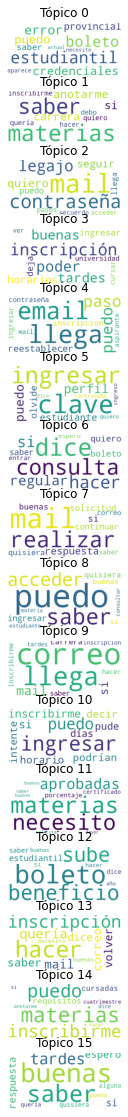

In [10]:
# WordClouds
wc_atributos = {'background_color' : 'white',
                'max_words' : 50
                } # Defino los parámetros que les voy a pasar a los wordclouds

# Creo la figura
fig, axs = plt.subplots(n_components, figsize = (6,20))

# Recorro para todas las componentes
for n in range(n_components):

  # 10 términos más pesados
  list_sorted = sorted(range(len(vocabulary)), reverse = True, key = lambda x: lda.components_[n][x])[:10]

  # Diccionario término: peso
  comp_dict = {vocabulary[i]: lda.components_[n][i] for i in list_sorted}

  # Creo el wordlcoud
  wc = WordCloud(**wc_atributos # De esta forma, le estoy diciendo a la función que expanda el diccionario de atributos de forma tal de que entienda lo que quiero que haga
                 ).generate_from_frequencies(comp_dict)

  axs[n].set_title('Tópico {}'.format(n))
  axs[n].imshow(wc)
  axs[n].axis('off')

plt.show()